SAIDL 2024 Spring Assignment

Author: Shanay Mehta

**Packages:**

In [1]:
import torch
from torch import nn
from torch.optim import *
from torchvision.datasets import *
from torchvision.transforms import *
from torch.optim.lr_scheduler import *
from torch.utils.data import DataLoader
from torchsummary import summary
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import numpy as np

**Device:**

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [3]:
torch.random.manual_seed(1)
np.random.seed(1)

**Loading the CIFAR 10 Dataset:**

In [4]:
image_size = 32
transforms = {
    # Data augmentation and normalisation
    "train": Compose([
        RandomCrop(image_size, padding=4),
        RandomHorizontalFlip(),
        ToTensor(),
        Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]) #normalise according to the
    ]),
    "test": Compose([
        ToTensor(),
        Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])
}
dataset = {}
for split in ["train", "test"]:
  dataset[split] = CIFAR10(
    root="data/cifar10",
    train=(split == "train"),
    download=True,
    transform=transforms[split],
  )
dataloader = {}
for split in ['train', 'test']:
  dataloader[split] = DataLoader(
    dataset[split],
    batch_size=512,
    shuffle=(split == 'train'),
    num_workers=0,
    pin_memory=True,
  )


100%|██████████| 170498071/170498071 [00:02<00:00, 80971239.59it/s]


Extracting data/cifar10/cifar-10-python.tar.gz to data/cifar10
Files already downloaded and verified


**Display image**

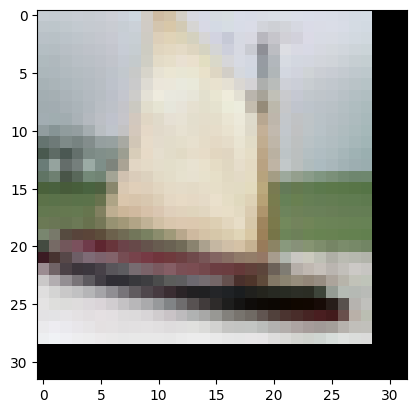

torch.Size([3, 32, 32])
tensor(8)


In [5]:
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# printing images
dataiter = iter(dataloader['train'])
images, labels = next(dataiter)

imshow(images[0])
print(images[0].shape)
print(labels[0])

**Train and Test functions**

In [6]:
def train(
  model: nn.Module,
  dataloader: DataLoader,
  criterion: nn.Module,
  optimizer: Optimizer,
  l2_lambda: float = 0.005,
) -> float:
  model.train()

  total_loss = 0.0

  for inputs, targets in tqdm(dataloader, desc='train', leave=False):
    # Move the data from CPU to GPU
    inputs = inputs.to(device)
    targets = targets.to(device)

    # Reset the gradients (from the last iteration)
    optimizer.zero_grad()

    # Forward inference
    outputs = model(inputs)
    loss = criterion(outputs, targets)

    # L2 regularization
    l2_reg = 0.0
    for param in model.parameters():
        l2_reg += torch.norm(param)**2
    loss += 0.5 * l2_lambda * l2_reg

    total_loss += loss.item() * inputs.size(0)

    # Backward propagation
    loss.backward()

    # Update optimizer
    optimizer.step()
  return total_loss/len(dataloader.dataset)

In [7]:
@torch.inference_mode()
def evaluate(
  model: nn.Module,
  dataloader: DataLoader,
  verbose=True,
) -> float:
  model.eval()

  num_samples = 0
  num_correct = 0

  for inputs, targets in tqdm(dataloader, desc="eval", leave=False,
                              disable=not verbose):
    # Move the data from CPU to GPU
    inputs = inputs.to(device)
    targets = targets.to(device)

    # Inference
    outputs = model(inputs)

    # Convert logits to class indices
    outputs = outputs.argmax(dim=1)

    # Update metrics
    num_samples += targets.size(0)
    num_correct += (outputs == targets).sum()

  return (num_correct / num_samples * 100).item()

**VGG Model**

In [8]:
# Code for the VGG16 class has been taken from: https://blog.paperspace.com/vgg-from-scratch-pytorch/
# This is done because VGG16 is a standard model and it is not the main focus of this project
class VGG16(nn.Module):
    def __init__(self, num_classes=10):
        super(VGG16, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU())
        self.layer2 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU())
        self.layer4 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer5 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU())
        self.layer6 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU())
        self.layer7 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.fc = nn.Sequential(
            nn.Linear(16*256, 1600),
            nn.Dropout(0.5),
            nn.ReLU())
        self.fc1 = nn.Sequential(
            nn.Linear(1600, 1000),
            nn.Dropout(0.5),
            nn.ReLU())
        self.fc2= nn.Sequential(
            nn.Linear(1000, num_classes))

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = self.layer6(out)
        out = self.layer7(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        out = self.fc1(out)
        out = self.fc2(out)
        return out


In [9]:
model = VGG16().to(device)

In [10]:
summary(model, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4           [-1, 64, 32, 32]          36,928
       BatchNorm2d-5           [-1, 64, 32, 32]             128
              ReLU-6           [-1, 64, 32, 32]               0
         MaxPool2d-7           [-1, 64, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]          73,856
       BatchNorm2d-9          [-1, 128, 16, 16]             256
             ReLU-10          [-1, 128, 16, 16]               0
           Conv2d-11          [-1, 128, 16, 16]         147,584
      BatchNorm2d-12          [-1, 128, 16, 16]             256
             ReLU-13          [-1, 128, 16, 16]               0
        MaxPool2d-14            [-1, 12

In [11]:
def get_num_parameters(model: nn.Module, count_nonzero_only=False) -> int:
    """
    calculate the total number of parameters of model
    :param count_nonzero_only: only count nonzero weights
    """
    num_counted_elements = 0
    for param in model.parameters():
        if count_nonzero_only:
            num_counted_elements += param.count_nonzero()
        else:
            num_counted_elements += param.numel()
    return num_counted_elements

In [12]:
def get_model_size(model: nn.Module, data_width=32, count_nonzero_only=False) -> int:
    """
    calculate the model size in bits
    :param data_width: #bits per element
    :param count_nonzero_only: only count nonzero weights
    """
    return get_num_parameters(model, count_nonzero_only) * data_width

In [13]:
model_size= get_model_size(model, data_width=32, count_nonzero_only=False)/(8*1024*1024)
print(f"Model size: {model_size:.2f} MiB")

Model size: 37.78 MiB


In [14]:
# Save the model to Google Drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [16]:
weights_history_path = '/content/drive/MyDrive/SAIDL_2024_Assignment/Pruning/weights_history.pth'
accuracy_history_path = '/content/drive/MyDrive/SAIDL_2024_Assignment/Pruning/accuracy_history.pth'
loss_history_path = '/content/drive/MyDrive/SAIDL_2024_Assignment/Pruning/loss_history.pth'

**Training the model**

In [17]:
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=0.001)

weights_history = []
accuracy_history = []
loss_history = []

num_epochs = 70

for epoch in range(num_epochs):
    loss = train(model, dataloader['train'], criterion, optimizer)
    accuracy = evaluate(model, dataloader['test'])

    # Store the weights, accuracy, and loss at every 5 epochs
    if (epoch + 1) % 5 == 0:
        weights_history.append(model.state_dict())
        accuracy_history.append(accuracy)
        loss_history.append(loss)
        torch.save(weights_history, weights_history_path)
        torch.save(accuracy_history, accuracy_history_path)
        torch.save(loss_history, loss_history_path)

    print(f"Epoch {epoch+1}/{num_epochs}, Test Accuracy: {accuracy:.2f}%, Train Loss: {loss:.4f}")

train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1/70, Test Accuracy: 30.32%, Train Loss: 5.8498


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2/70, Test Accuracy: 51.25%, Train Loss: 4.0197


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3/70, Test Accuracy: 57.74%, Train Loss: 3.3013


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4/70, Test Accuracy: 56.63%, Train Loss: 2.8065


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 5/70, Test Accuracy: 61.67%, Train Loss: 2.4359


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 6/70, Test Accuracy: 66.39%, Train Loss: 2.1324


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 7/70, Test Accuracy: 71.56%, Train Loss: 1.8853


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 8/70, Test Accuracy: 68.46%, Train Loss: 1.7015


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 9/70, Test Accuracy: 74.48%, Train Loss: 1.5424


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 10/70, Test Accuracy: 67.10%, Train Loss: 1.4231


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 11/70, Test Accuracy: 74.06%, Train Loss: 1.3230


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 12/70, Test Accuracy: 79.08%, Train Loss: 1.2293


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 13/70, Test Accuracy: 67.53%, Train Loss: 1.1758


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 14/70, Test Accuracy: 73.59%, Train Loss: 1.1327


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 15/70, Test Accuracy: 74.16%, Train Loss: 1.0802


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 16/70, Test Accuracy: 79.35%, Train Loss: 1.0550


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 17/70, Test Accuracy: 72.32%, Train Loss: 1.0169


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 18/70, Test Accuracy: 72.36%, Train Loss: 0.9904


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 19/70, Test Accuracy: 79.55%, Train Loss: 0.9824


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 20/70, Test Accuracy: 80.80%, Train Loss: 0.9623


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 21/70, Test Accuracy: 77.38%, Train Loss: 0.9471


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 22/70, Test Accuracy: 79.70%, Train Loss: 0.9257


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 23/70, Test Accuracy: 82.57%, Train Loss: 0.9052


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 24/70, Test Accuracy: 79.37%, Train Loss: 0.9033


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 25/70, Test Accuracy: 77.79%, Train Loss: 0.8970


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 26/70, Test Accuracy: 80.93%, Train Loss: 0.8877


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 27/70, Test Accuracy: 81.01%, Train Loss: 0.8834


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 28/70, Test Accuracy: 80.69%, Train Loss: 0.8720


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 29/70, Test Accuracy: 82.57%, Train Loss: 0.8621


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 30/70, Test Accuracy: 82.18%, Train Loss: 0.8503


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 31/70, Test Accuracy: 83.99%, Train Loss: 0.8501


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 32/70, Test Accuracy: 80.23%, Train Loss: 0.8319


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 33/70, Test Accuracy: 78.04%, Train Loss: 0.8339


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 34/70, Test Accuracy: 82.23%, Train Loss: 0.8273


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 35/70, Test Accuracy: 84.19%, Train Loss: 0.8267


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 36/70, Test Accuracy: 83.02%, Train Loss: 0.8190


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 37/70, Test Accuracy: 76.30%, Train Loss: 0.8079


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 38/70, Test Accuracy: 84.93%, Train Loss: 0.8115


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 39/70, Test Accuracy: 80.68%, Train Loss: 0.8051


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 40/70, Test Accuracy: 85.00%, Train Loss: 0.7943


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 41/70, Test Accuracy: 86.35%, Train Loss: 0.7927


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 42/70, Test Accuracy: 83.67%, Train Loss: 0.7879


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 43/70, Test Accuracy: 79.60%, Train Loss: 0.7897


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 44/70, Test Accuracy: 84.40%, Train Loss: 0.7947


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 45/70, Test Accuracy: 83.13%, Train Loss: 0.7880


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 46/70, Test Accuracy: 81.41%, Train Loss: 0.7766


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 47/70, Test Accuracy: 85.26%, Train Loss: 0.7746


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 48/70, Test Accuracy: 82.67%, Train Loss: 0.7727


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 49/70, Test Accuracy: 84.49%, Train Loss: 0.7597


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 50/70, Test Accuracy: 83.72%, Train Loss: 0.7716


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 51/70, Test Accuracy: 83.64%, Train Loss: 0.7613


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 52/70, Test Accuracy: 85.31%, Train Loss: 0.7722


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 53/70, Test Accuracy: 84.88%, Train Loss: 0.7555


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 54/70, Test Accuracy: 80.07%, Train Loss: 0.7475


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 55/70, Test Accuracy: 81.16%, Train Loss: 0.7375


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 56/70, Test Accuracy: 84.58%, Train Loss: 0.7489


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 57/70, Test Accuracy: 84.15%, Train Loss: 0.7463


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 58/70, Test Accuracy: 82.50%, Train Loss: 0.7422


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 59/70, Test Accuracy: 83.88%, Train Loss: 0.7486


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 60/70, Test Accuracy: 82.46%, Train Loss: 0.7421


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 61/70, Test Accuracy: 86.07%, Train Loss: 0.7354


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 62/70, Test Accuracy: 80.51%, Train Loss: 0.7357


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 63/70, Test Accuracy: 83.97%, Train Loss: 0.7311


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 64/70, Test Accuracy: 83.04%, Train Loss: 0.7307


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 65/70, Test Accuracy: 83.65%, Train Loss: 0.7242


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 66/70, Test Accuracy: 84.68%, Train Loss: 0.7213


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 67/70, Test Accuracy: 85.25%, Train Loss: 0.7205


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 68/70, Test Accuracy: 86.99%, Train Loss: 0.7193


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 69/70, Test Accuracy: 80.46%, Train Loss: 0.7203


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 70/70, Test Accuracy: 84.81%, Train Loss: 0.7162


In [18]:
# Load the saved model
load_path = '/content/drive/MyDrive/SAIDL_2024_Assignment/Pruning/weights_history.pth'
loaded_model = VGG16().to(device)
loaded_model.load_state_dict(torch.load(load_path, map_location=torch.device('cpu'))[-1])
print(f"Model loaded from {load_path}")

Model loaded from /content/drive/MyDrive/SAIDL_2024_Assignment/Pruning/weights_history.pth


In [20]:
accuracy = evaluate(loaded_model, dataloader['test'])
print(f"Test Accuracy: {accuracy:.2f}%")

eval:   0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy: 84.81%


**Pruning**

In [21]:
def prune_layer(model: nn.Module, layer_name: str, prune_percent: float):
    """
    Prune a specified percentage of weights in a layer using argmin method.
    :param model: The model to be pruned.
    :param layer_name: The name of the layer to be pruned.
    :param prune_percent: The percentage of weights to be pruned.
    """
    layer = getattr(model, layer_name)
    weights = layer[0].weight.data
    num_weights = weights.numel()
    num_prune = int(num_weights * prune_percent)
    flat_weights = weights.view(-1)
    _, indices = torch.topk(torch.abs(flat_weights), num_prune, largest=False)
    flat_weights[indices] = 0.0
    weights.data = flat_weights.view(weights.size())

In [22]:
prune_per = list(range(0, 91, 10))
accuracy_values = []

for prune_percent in prune_per:
    # Load the saved model
    load_path = '/content/drive/MyDrive/SAIDL_2024_Assignment/Pruning/weights_history.pth'
    loaded_model = VGG16().to(device)
    loaded_model.load_state_dict(torch.load(load_path, map_location=torch.device('cpu'))[-1])
    print(f"Model loaded from {load_path}")

    # Prune the specified percentage of layer 1
    prune_layer(loaded_model, 'layer1', prune_percent / 100.0)

    # Evaluate the pruned model
    accuracy = evaluate(loaded_model, dataloader['test'])
    print(f"Test Accuracy with {prune_percent}% pruning: {accuracy:.2f}%")

    accuracy_values.append(accuracy)

Model loaded from /content/drive/MyDrive/SAIDL_2024_Assignment/Pruning/weights_history.pth


eval:   0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy with 0% pruning: 84.81%
Model loaded from /content/drive/MyDrive/SAIDL_2024_Assignment/Pruning/weights_history.pth


eval:   0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy with 10% pruning: 84.81%
Model loaded from /content/drive/MyDrive/SAIDL_2024_Assignment/Pruning/weights_history.pth


eval:   0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy with 20% pruning: 84.81%
Model loaded from /content/drive/MyDrive/SAIDL_2024_Assignment/Pruning/weights_history.pth


eval:   0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy with 30% pruning: 84.75%
Model loaded from /content/drive/MyDrive/SAIDL_2024_Assignment/Pruning/weights_history.pth


eval:   0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy with 40% pruning: 84.53%
Model loaded from /content/drive/MyDrive/SAIDL_2024_Assignment/Pruning/weights_history.pth


eval:   0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy with 50% pruning: 84.12%
Model loaded from /content/drive/MyDrive/SAIDL_2024_Assignment/Pruning/weights_history.pth


eval:   0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy with 60% pruning: 82.76%
Model loaded from /content/drive/MyDrive/SAIDL_2024_Assignment/Pruning/weights_history.pth


eval:   0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy with 70% pruning: 76.31%
Model loaded from /content/drive/MyDrive/SAIDL_2024_Assignment/Pruning/weights_history.pth


eval:   0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy with 80% pruning: 66.34%
Model loaded from /content/drive/MyDrive/SAIDL_2024_Assignment/Pruning/weights_history.pth


eval:   0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy with 90% pruning: 49.82%


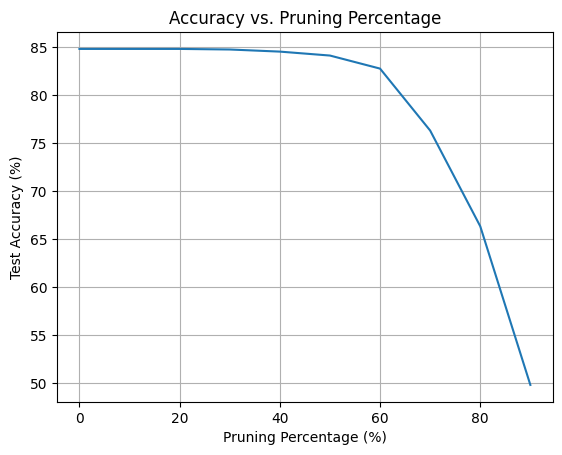

In [23]:
# Plot accuracy vs. pruning percentage
plt.plot(prune_per, accuracy_values)
plt.xlabel('Pruning Percentage (%)')
plt.ylabel('Test Accuracy (%)')
plt.title('Accuracy vs. Pruning Percentage')
plt.grid(True)
plt.show()

In [24]:
# Plot accuracy vs. pruning percentage for all layers
layer_names = ['layer1', 'layer2', 'layer3', 'layer4', 'layer5', 'layer6', 'layer7', 'fc', 'fc1', 'fc2']
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'purple', 'orange', 'brown']
prune_per = list(range(0, 91, 10))
accuracy_values = [[] for _ in range(len(layer_names))]

for layer_idx, layer_name in enumerate(layer_names):
    for prune_percent in prune_per:
        # Load the saved model
        load_path = '/content/drive/MyDrive/SAIDL_2024_Assignment/Pruning/weights_history.pth'
        loaded_model = VGG16().to(device)
        loaded_model.load_state_dict(torch.load(load_path, map_location=torch.device('cpu'))[-1])
        print(f"Model loaded from {load_path}")
        # Prune the specified percentage of the layer
        prune_layer(loaded_model, layer_name, prune_percent / 100.0)
        # Evaluate the pruned model
        accuracy = evaluate(loaded_model, dataloader['test'])
        print(f"Test Accuracy with {prune_percent}% pruning for {layer_name}: {accuracy:.2f}%")
        accuracy_values[layer_idx].append(accuracy)


Model loaded from /content/drive/MyDrive/SAIDL_2024_Assignment/Pruning/weights_history.pth


eval:   0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy with 0% pruning for layer1: 84.81%
Model loaded from /content/drive/MyDrive/SAIDL_2024_Assignment/Pruning/weights_history.pth


eval:   0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy with 10% pruning for layer1: 84.81%
Model loaded from /content/drive/MyDrive/SAIDL_2024_Assignment/Pruning/weights_history.pth


eval:   0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy with 20% pruning for layer1: 84.81%
Model loaded from /content/drive/MyDrive/SAIDL_2024_Assignment/Pruning/weights_history.pth


eval:   0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy with 30% pruning for layer1: 84.75%
Model loaded from /content/drive/MyDrive/SAIDL_2024_Assignment/Pruning/weights_history.pth


eval:   0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy with 40% pruning for layer1: 84.53%
Model loaded from /content/drive/MyDrive/SAIDL_2024_Assignment/Pruning/weights_history.pth


eval:   0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy with 50% pruning for layer1: 84.12%
Model loaded from /content/drive/MyDrive/SAIDL_2024_Assignment/Pruning/weights_history.pth


eval:   0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy with 60% pruning for layer1: 82.76%
Model loaded from /content/drive/MyDrive/SAIDL_2024_Assignment/Pruning/weights_history.pth


eval:   0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy with 70% pruning for layer1: 76.31%
Model loaded from /content/drive/MyDrive/SAIDL_2024_Assignment/Pruning/weights_history.pth


eval:   0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy with 80% pruning for layer1: 66.34%
Model loaded from /content/drive/MyDrive/SAIDL_2024_Assignment/Pruning/weights_history.pth


eval:   0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy with 90% pruning for layer1: 49.82%
Model loaded from /content/drive/MyDrive/SAIDL_2024_Assignment/Pruning/weights_history.pth


eval:   0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy with 0% pruning for layer2: 84.81%
Model loaded from /content/drive/MyDrive/SAIDL_2024_Assignment/Pruning/weights_history.pth


eval:   0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy with 10% pruning for layer2: 84.81%
Model loaded from /content/drive/MyDrive/SAIDL_2024_Assignment/Pruning/weights_history.pth


eval:   0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy with 20% pruning for layer2: 84.81%
Model loaded from /content/drive/MyDrive/SAIDL_2024_Assignment/Pruning/weights_history.pth


eval:   0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy with 30% pruning for layer2: 84.81%
Model loaded from /content/drive/MyDrive/SAIDL_2024_Assignment/Pruning/weights_history.pth


eval:   0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy with 40% pruning for layer2: 84.82%
Model loaded from /content/drive/MyDrive/SAIDL_2024_Assignment/Pruning/weights_history.pth


eval:   0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy with 50% pruning for layer2: 84.83%
Model loaded from /content/drive/MyDrive/SAIDL_2024_Assignment/Pruning/weights_history.pth


eval:   0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy with 60% pruning for layer2: 84.76%
Model loaded from /content/drive/MyDrive/SAIDL_2024_Assignment/Pruning/weights_history.pth


eval:   0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy with 70% pruning for layer2: 84.46%
Model loaded from /content/drive/MyDrive/SAIDL_2024_Assignment/Pruning/weights_history.pth


eval:   0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy with 80% pruning for layer2: 83.65%
Model loaded from /content/drive/MyDrive/SAIDL_2024_Assignment/Pruning/weights_history.pth


eval:   0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy with 90% pruning for layer2: 78.84%
Model loaded from /content/drive/MyDrive/SAIDL_2024_Assignment/Pruning/weights_history.pth


eval:   0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy with 0% pruning for layer3: 84.81%
Model loaded from /content/drive/MyDrive/SAIDL_2024_Assignment/Pruning/weights_history.pth


eval:   0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy with 10% pruning for layer3: 84.81%
Model loaded from /content/drive/MyDrive/SAIDL_2024_Assignment/Pruning/weights_history.pth


eval:   0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy with 20% pruning for layer3: 84.81%
Model loaded from /content/drive/MyDrive/SAIDL_2024_Assignment/Pruning/weights_history.pth


eval:   0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy with 30% pruning for layer3: 84.81%
Model loaded from /content/drive/MyDrive/SAIDL_2024_Assignment/Pruning/weights_history.pth


eval:   0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy with 40% pruning for layer3: 84.81%
Model loaded from /content/drive/MyDrive/SAIDL_2024_Assignment/Pruning/weights_history.pth


eval:   0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy with 50% pruning for layer3: 84.79%
Model loaded from /content/drive/MyDrive/SAIDL_2024_Assignment/Pruning/weights_history.pth


eval:   0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy with 60% pruning for layer3: 84.97%
Model loaded from /content/drive/MyDrive/SAIDL_2024_Assignment/Pruning/weights_history.pth


eval:   0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy with 70% pruning for layer3: 84.68%
Model loaded from /content/drive/MyDrive/SAIDL_2024_Assignment/Pruning/weights_history.pth


eval:   0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy with 80% pruning for layer3: 84.28%
Model loaded from /content/drive/MyDrive/SAIDL_2024_Assignment/Pruning/weights_history.pth


eval:   0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy with 90% pruning for layer3: 80.98%
Model loaded from /content/drive/MyDrive/SAIDL_2024_Assignment/Pruning/weights_history.pth


eval:   0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy with 0% pruning for layer4: 84.81%
Model loaded from /content/drive/MyDrive/SAIDL_2024_Assignment/Pruning/weights_history.pth


eval:   0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy with 10% pruning for layer4: 84.81%
Model loaded from /content/drive/MyDrive/SAIDL_2024_Assignment/Pruning/weights_history.pth


eval:   0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy with 20% pruning for layer4: 84.81%
Model loaded from /content/drive/MyDrive/SAIDL_2024_Assignment/Pruning/weights_history.pth


eval:   0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy with 30% pruning for layer4: 84.81%
Model loaded from /content/drive/MyDrive/SAIDL_2024_Assignment/Pruning/weights_history.pth


eval:   0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy with 40% pruning for layer4: 84.81%
Model loaded from /content/drive/MyDrive/SAIDL_2024_Assignment/Pruning/weights_history.pth


eval:   0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy with 50% pruning for layer4: 84.80%
Model loaded from /content/drive/MyDrive/SAIDL_2024_Assignment/Pruning/weights_history.pth


eval:   0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy with 60% pruning for layer4: 84.70%
Model loaded from /content/drive/MyDrive/SAIDL_2024_Assignment/Pruning/weights_history.pth


eval:   0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy with 70% pruning for layer4: 84.82%
Model loaded from /content/drive/MyDrive/SAIDL_2024_Assignment/Pruning/weights_history.pth


eval:   0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy with 80% pruning for layer4: 83.13%
Model loaded from /content/drive/MyDrive/SAIDL_2024_Assignment/Pruning/weights_history.pth


eval:   0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy with 90% pruning for layer4: 71.81%
Model loaded from /content/drive/MyDrive/SAIDL_2024_Assignment/Pruning/weights_history.pth


eval:   0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy with 0% pruning for layer5: 84.81%
Model loaded from /content/drive/MyDrive/SAIDL_2024_Assignment/Pruning/weights_history.pth


eval:   0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy with 10% pruning for layer5: 84.81%
Model loaded from /content/drive/MyDrive/SAIDL_2024_Assignment/Pruning/weights_history.pth


eval:   0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy with 20% pruning for layer5: 84.81%
Model loaded from /content/drive/MyDrive/SAIDL_2024_Assignment/Pruning/weights_history.pth


eval:   0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy with 30% pruning for layer5: 84.81%
Model loaded from /content/drive/MyDrive/SAIDL_2024_Assignment/Pruning/weights_history.pth


eval:   0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy with 40% pruning for layer5: 84.81%
Model loaded from /content/drive/MyDrive/SAIDL_2024_Assignment/Pruning/weights_history.pth


eval:   0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy with 50% pruning for layer5: 84.81%
Model loaded from /content/drive/MyDrive/SAIDL_2024_Assignment/Pruning/weights_history.pth


eval:   0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy with 60% pruning for layer5: 84.81%
Model loaded from /content/drive/MyDrive/SAIDL_2024_Assignment/Pruning/weights_history.pth


eval:   0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy with 70% pruning for layer5: 84.81%
Model loaded from /content/drive/MyDrive/SAIDL_2024_Assignment/Pruning/weights_history.pth


eval:   0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy with 80% pruning for layer5: 84.91%
Model loaded from /content/drive/MyDrive/SAIDL_2024_Assignment/Pruning/weights_history.pth


eval:   0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy with 90% pruning for layer5: 85.32%
Model loaded from /content/drive/MyDrive/SAIDL_2024_Assignment/Pruning/weights_history.pth


eval:   0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy with 0% pruning for layer6: 84.81%
Model loaded from /content/drive/MyDrive/SAIDL_2024_Assignment/Pruning/weights_history.pth


eval:   0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy with 10% pruning for layer6: 84.81%
Model loaded from /content/drive/MyDrive/SAIDL_2024_Assignment/Pruning/weights_history.pth


eval:   0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy with 20% pruning for layer6: 84.81%
Model loaded from /content/drive/MyDrive/SAIDL_2024_Assignment/Pruning/weights_history.pth


eval:   0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy with 30% pruning for layer6: 84.81%
Model loaded from /content/drive/MyDrive/SAIDL_2024_Assignment/Pruning/weights_history.pth


eval:   0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy with 40% pruning for layer6: 84.81%
Model loaded from /content/drive/MyDrive/SAIDL_2024_Assignment/Pruning/weights_history.pth


eval:   0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy with 50% pruning for layer6: 84.81%
Model loaded from /content/drive/MyDrive/SAIDL_2024_Assignment/Pruning/weights_history.pth


eval:   0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy with 60% pruning for layer6: 84.81%
Model loaded from /content/drive/MyDrive/SAIDL_2024_Assignment/Pruning/weights_history.pth


eval:   0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy with 70% pruning for layer6: 84.81%
Model loaded from /content/drive/MyDrive/SAIDL_2024_Assignment/Pruning/weights_history.pth


eval:   0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy with 80% pruning for layer6: 84.81%
Model loaded from /content/drive/MyDrive/SAIDL_2024_Assignment/Pruning/weights_history.pth


eval:   0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy with 90% pruning for layer6: 84.81%
Model loaded from /content/drive/MyDrive/SAIDL_2024_Assignment/Pruning/weights_history.pth


eval:   0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy with 0% pruning for layer7: 84.81%
Model loaded from /content/drive/MyDrive/SAIDL_2024_Assignment/Pruning/weights_history.pth


eval:   0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy with 10% pruning for layer7: 84.81%
Model loaded from /content/drive/MyDrive/SAIDL_2024_Assignment/Pruning/weights_history.pth


eval:   0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy with 20% pruning for layer7: 84.81%
Model loaded from /content/drive/MyDrive/SAIDL_2024_Assignment/Pruning/weights_history.pth


eval:   0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy with 30% pruning for layer7: 84.81%
Model loaded from /content/drive/MyDrive/SAIDL_2024_Assignment/Pruning/weights_history.pth


eval:   0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy with 40% pruning for layer7: 84.81%
Model loaded from /content/drive/MyDrive/SAIDL_2024_Assignment/Pruning/weights_history.pth


eval:   0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy with 50% pruning for layer7: 84.81%
Model loaded from /content/drive/MyDrive/SAIDL_2024_Assignment/Pruning/weights_history.pth


eval:   0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy with 60% pruning for layer7: 84.81%
Model loaded from /content/drive/MyDrive/SAIDL_2024_Assignment/Pruning/weights_history.pth


eval:   0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy with 70% pruning for layer7: 84.81%
Model loaded from /content/drive/MyDrive/SAIDL_2024_Assignment/Pruning/weights_history.pth


eval:   0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy with 80% pruning for layer7: 84.81%
Model loaded from /content/drive/MyDrive/SAIDL_2024_Assignment/Pruning/weights_history.pth


eval:   0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy with 90% pruning for layer7: 84.81%
Model loaded from /content/drive/MyDrive/SAIDL_2024_Assignment/Pruning/weights_history.pth


eval:   0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy with 0% pruning for fc: 84.81%
Model loaded from /content/drive/MyDrive/SAIDL_2024_Assignment/Pruning/weights_history.pth


eval:   0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy with 10% pruning for fc: 84.81%
Model loaded from /content/drive/MyDrive/SAIDL_2024_Assignment/Pruning/weights_history.pth


eval:   0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy with 20% pruning for fc: 84.81%
Model loaded from /content/drive/MyDrive/SAIDL_2024_Assignment/Pruning/weights_history.pth


eval:   0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy with 30% pruning for fc: 84.81%
Model loaded from /content/drive/MyDrive/SAIDL_2024_Assignment/Pruning/weights_history.pth


eval:   0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy with 40% pruning for fc: 84.81%
Model loaded from /content/drive/MyDrive/SAIDL_2024_Assignment/Pruning/weights_history.pth


eval:   0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy with 50% pruning for fc: 84.81%
Model loaded from /content/drive/MyDrive/SAIDL_2024_Assignment/Pruning/weights_history.pth


eval:   0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy with 60% pruning for fc: 84.81%
Model loaded from /content/drive/MyDrive/SAIDL_2024_Assignment/Pruning/weights_history.pth


eval:   0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy with 70% pruning for fc: 84.81%
Model loaded from /content/drive/MyDrive/SAIDL_2024_Assignment/Pruning/weights_history.pth


eval:   0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy with 80% pruning for fc: 84.81%
Model loaded from /content/drive/MyDrive/SAIDL_2024_Assignment/Pruning/weights_history.pth


eval:   0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy with 90% pruning for fc: 84.81%
Model loaded from /content/drive/MyDrive/SAIDL_2024_Assignment/Pruning/weights_history.pth


eval:   0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy with 0% pruning for fc1: 84.81%
Model loaded from /content/drive/MyDrive/SAIDL_2024_Assignment/Pruning/weights_history.pth


eval:   0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy with 10% pruning for fc1: 84.81%
Model loaded from /content/drive/MyDrive/SAIDL_2024_Assignment/Pruning/weights_history.pth


eval:   0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy with 20% pruning for fc1: 84.81%
Model loaded from /content/drive/MyDrive/SAIDL_2024_Assignment/Pruning/weights_history.pth


eval:   0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy with 30% pruning for fc1: 84.81%
Model loaded from /content/drive/MyDrive/SAIDL_2024_Assignment/Pruning/weights_history.pth


eval:   0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy with 40% pruning for fc1: 84.81%
Model loaded from /content/drive/MyDrive/SAIDL_2024_Assignment/Pruning/weights_history.pth


eval:   0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy with 50% pruning for fc1: 84.81%
Model loaded from /content/drive/MyDrive/SAIDL_2024_Assignment/Pruning/weights_history.pth


eval:   0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy with 60% pruning for fc1: 84.81%
Model loaded from /content/drive/MyDrive/SAIDL_2024_Assignment/Pruning/weights_history.pth


eval:   0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy with 70% pruning for fc1: 84.81%
Model loaded from /content/drive/MyDrive/SAIDL_2024_Assignment/Pruning/weights_history.pth


eval:   0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy with 80% pruning for fc1: 84.81%
Model loaded from /content/drive/MyDrive/SAIDL_2024_Assignment/Pruning/weights_history.pth


eval:   0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy with 90% pruning for fc1: 84.82%
Model loaded from /content/drive/MyDrive/SAIDL_2024_Assignment/Pruning/weights_history.pth


eval:   0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy with 0% pruning for fc2: 84.81%
Model loaded from /content/drive/MyDrive/SAIDL_2024_Assignment/Pruning/weights_history.pth


eval:   0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy with 10% pruning for fc2: 84.81%
Model loaded from /content/drive/MyDrive/SAIDL_2024_Assignment/Pruning/weights_history.pth


eval:   0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy with 20% pruning for fc2: 84.81%
Model loaded from /content/drive/MyDrive/SAIDL_2024_Assignment/Pruning/weights_history.pth


eval:   0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy with 30% pruning for fc2: 84.81%
Model loaded from /content/drive/MyDrive/SAIDL_2024_Assignment/Pruning/weights_history.pth


eval:   0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy with 40% pruning for fc2: 84.80%
Model loaded from /content/drive/MyDrive/SAIDL_2024_Assignment/Pruning/weights_history.pth


eval:   0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy with 50% pruning for fc2: 84.78%
Model loaded from /content/drive/MyDrive/SAIDL_2024_Assignment/Pruning/weights_history.pth


eval:   0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy with 60% pruning for fc2: 84.86%
Model loaded from /content/drive/MyDrive/SAIDL_2024_Assignment/Pruning/weights_history.pth


eval:   0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy with 70% pruning for fc2: 84.83%
Model loaded from /content/drive/MyDrive/SAIDL_2024_Assignment/Pruning/weights_history.pth


eval:   0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy with 80% pruning for fc2: 84.88%
Model loaded from /content/drive/MyDrive/SAIDL_2024_Assignment/Pruning/weights_history.pth


eval:   0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy with 90% pruning for fc2: 84.04%


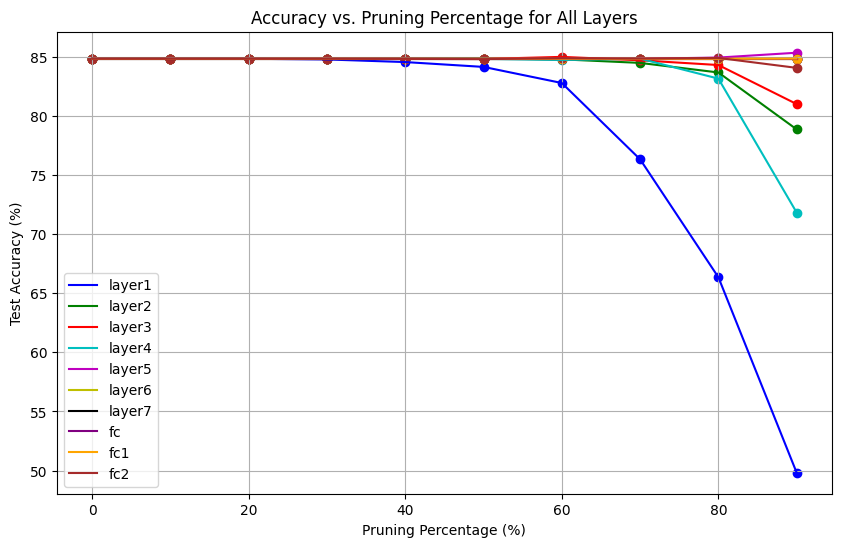

In [25]:
# Plotting
plt.figure(figsize=(10, 6))
for layer_idx, layer_name in enumerate(layer_names):
    plt.plot(prune_per, accuracy_values[layer_idx], color=colors[layer_idx], label=layer_name)

for layer_idx, layer_name in enumerate(layer_names):
    plt.scatter(prune_per, accuracy_values[layer_idx], color=colors[layer_idx])

plt.xlabel('Pruning Percentage (%)')
plt.ylabel('Test Accuracy (%)')
plt.title('Accuracy vs. Pruning Percentage for All Layers')
plt.legend()
plt.grid(True)
plt.show()

In [26]:
load_path = '/content/drive/MyDrive/SAIDL_2024_Assignment/Pruning/weights_history.pth'
loaded_model = VGG16().to(device)
loaded_model.load_state_dict(torch.load(load_path, map_location=torch.device('cpu'))[-1])
print(f"Model loaded from {load_path}")

prune_layer(loaded_model, 'layer1', 70 / 100.0)
prune_layer(loaded_model, 'layer2', 80 / 100.0)
prune_layer(loaded_model, 'layer3', 90 / 100.0)
prune_layer(loaded_model, 'layer4', 90 / 100.0)
prune_layer(loaded_model, 'layer5', 90 / 100.0)
prune_layer(loaded_model, 'layer6', 90 / 100.0)
prune_layer(loaded_model, 'layer7', 90 / 100.0)
prune_layer(loaded_model, 'fc', 90 / 100.0)
prune_layer(loaded_model, 'fc1', 90 / 100.0)
prune_layer(loaded_model, 'fc2', 90 / 100.0)

Model loaded from /content/drive/MyDrive/SAIDL_2024_Assignment/Pruning/weights_history.pth


In [29]:
model_size= get_model_size(loaded_model, data_width=32, count_nonzero_only=True)/(8*1024*1024)
print(f"Pruned model size: {model_size:.2f} MiB")

Pruned model size: 3.81 MiB


In [30]:
# Evaluate the pruned model
accuracy = evaluate(loaded_model, dataloader['test'])
print(f"Test Accuracy with pruned model of size {model_size:.2f} MiB: {accuracy:.2f}%")

eval:   0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy with pruned model of size 3.81 MiB: 61.03%


*Note: The model size was initially 37.78 MiB with an accuracy of 84.81% and the size of the pruned model is 3.81 MiB(Approximately 10 times smaller) with an accuracy of 61.03%. **